<a href="https://colab.research.google.com/github/suhayb-h/Acute-Lymphoblastic-Leukemia-Classifier/blob/main/ARC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
import helper
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import math
import os
import argparse
from torch.autograd import Variable
from datetime import datetime, timedelta
import urllib.request
import numpy as np
import zipfile
from numpy.random import choice
from torch.autograd import Variable
from skimage import transform as tf
import random
import matplotlib as mpl
import scipy
from imageio import imread

In [16]:
transform = transforms.Compose([transforms.ToTensor()])

dataset = \
datasets.ImageFolder(
    '/content/drive/Othercomputers/My MacBook Air/C-NMC_Leukemia/training_data', 
    transform=transform
    )

dataloader = \
torch.utils.data.DataLoader(
    dataset, 
    batch_size = 100, 
    shuffle = True
    )

images, labels = next(iter(dataloader))

TypeError: ignored

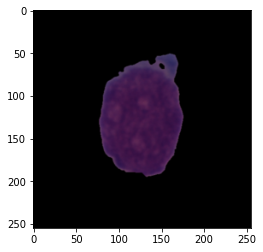

In [38]:
plt.imshow(images[0].permute(1, 2, 0)).axes('off')
#plt.imshow(images[0])

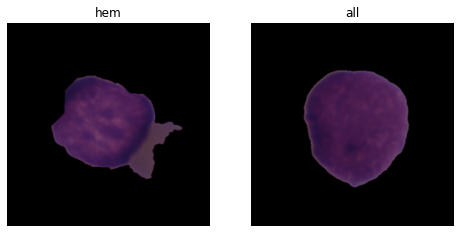

In [34]:
labels_map = {
    0: "hem",
    1: "all"
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 2, 1
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    img, label = dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze().permute(1,2))
plt.show()

In [58]:
"""
taken and modified from https://github.com/pranv/ARC
"""

class Omniglot(object):
    def __init__(self, path=os.path.join('data', 'omniglot.npy'), batch_size=128, image_size=32):
        """
        batch_size: the output is (2 * batch size, 1, image_size, image_size)
                    X[i] & X[i + batch_size] are the pair
        image_size: size of the image
        data_split: in number of alphabets, e.g. [30, 10] means out of 50 Omniglot characters,
                    30 is for training, 10 for validation and the remaining(10) for testing
        within_alphabet: for verfication task, when 2 characters are sampled to form a pair,
                        this flag specifies if should they be from the same alphabet/language
        ---------------------
        Data Augmentation Parameters:
            flip: here flipping both the images in a pair
            scale: x would scale image by + or - x%
            rotation_deg
            shear_deg
            translation_px: in both x and y directions
        """
        chars = np.load(path)

        # resize the images
        resized_chars = np.zeros((1623, 20, image_size, image_size), dtype='uint8')
        for i in range(1623):
            for j in range(20):
                resized_chars[i, j] = resize(chars[i, j], (image_size, image_size))
        chars = resized_chars

        self.mean_pixel = chars.mean() / 255.0  # used later for mean subtraction

        # starting index of each alphabet in a list of chars
        a_start = [0, 20, 49, 75, 116, 156, 180, 226, 240, 266, 300, 333, 355, 381,
                   424, 448, 496, 518, 534, 586, 633, 673, 699, 739, 780, 813,
                   827, 869, 892, 909, 964, 984, 1010, 1036, 1062, 1088, 1114,
                   1159, 1204, 1245, 1271, 1318, 1358, 1388, 1433, 1479, 1507,
                   1530, 1555, 1597]

        # size of each alphabet (num of chars)
        a_size = [20, 29, 26, 41, 40, 24, 46, 14, 26, 34, 33, 22, 26, 43, 24, 48, 22,
                  16, 52, 47, 40, 26, 40, 41, 33, 14, 42, 23, 17, 55, 20, 26, 26, 26,
                  26, 26, 45, 45, 41, 26, 47, 40, 30, 45, 46, 28, 23, 25, 42, 26]

        # each alphabet/language has different number of characters.
        # in order to uniformly sample all characters, we need weigh the probability
        # of sampling a alphabet by its size. p is that probability
        def size2p(size):
            s = np.array(size).astype('float64')
            return s / s.sum()

        self.size2p = size2p

        self.data = chars
        self.a_start = a_start
        self.a_size = a_size
        self.image_size = image_size
        self.batch_size = batch_size

        flip = True
        scale = 0.2
        rotation_deg = 20
        shear_deg = 10
        translation_px = 5
        self.augmentor = ImageAugmenter(image_size, image_size,
                                        hflip=flip, vflip=flip,
                                        scale_to_percent=1.0 + scale, rotation_deg=rotation_deg, shear_deg=shear_deg,
                                        translation_x_px=translation_px, translation_y_px=translation_px)

    def fetch_batch(self, part):
        """
            This outputs batch_size number of pairs
            Thus the actual number of images outputted is 2 * batch_size
            Say A & B form the half of a pair
            The Batch is divided into 4 parts:
                Dissimilar A 		Dissimilar B
                Similar A 			Similar B
            Corresponding images in Similar A and Similar B form the similar pair
            similarly, Dissimilar A and Dissimilar B form the dissimilar pair
            When flattened, the batch has 4 parts with indices:
                Dissimilar A 		0 - batch_size / 2
                Similar A    		batch_size / 2  - batch_size
                Dissimilar B 		batch_size  - 3 * batch_size / 2
                Similar B 			3 * batch_size / 2 - batch_size
        """
        pass


class Batcher(Omniglot):
    def __init__(self, path=os.path.join('data', 'omniglot.npy'), batch_size=128, image_size=32):
        Omniglot.__init__(self, path, batch_size, image_size)

        a_start = self.a_start
        a_size = self.a_size

        # slicing indices for splitting a_start & a_size
        i = 20
        j = 30
        starts = {}
        starts['train'], starts['val'], starts['test'] = a_start[:i], a_start[i:j], a_start[j:]
        sizes = {}
        sizes['train'], sizes['val'], sizes['test'] = a_size[:i], a_size[i:j], a_size[j:]

        size2p = self.size2p

        p = {}
        p['train'], p['val'], p['test'] = size2p(sizes['train']), size2p(sizes['val']), size2p(sizes['test'])

        self.starts = starts
        self.sizes = sizes
        self.p = p

    def fetch_batch(self, part, batch_size: int = None):

        if batch_size is None:
            batch_size = self.batch_size

        X, Y = self._fetch_batch(part, batch_size)

        X = Variable(torch.from_numpy(X)).view(2*batch_size, self.image_size, self.image_size)

        X1 = X[:batch_size]  # (B, h, w)
        X2 = X[batch_size:]  # (B, h, w)

        X = torch.stack([X1, X2], dim=1)  # (B, 2, h, w)

        Y = Variable(torch.from_numpy(Y))

        if use_cuda:
            X, Y = X.cuda(), Y.cuda()

        return X, Y

    def _fetch_batch(self, part, batch_size: int = None):
        if batch_size is None:
            batch_size = self.batch_size

        data = self.data
        starts = self.starts[part]
        sizes = self.sizes[part]
        p = self.p[part]
        image_size = self.image_size

        num_alphbts = len(starts)

        X = np.zeros((2 * batch_size, image_size, image_size), dtype='uint8')
        for i in range(batch_size // 2):
            # choose similar chars
            same_idx = choice(range(starts[0], starts[-1] + sizes[-1]))

            # choose dissimilar chars within alphabet
            alphbt_idx = choice(num_alphbts, p=p)
            char_offset = choice(sizes[alphbt_idx], 2, replace=False)
            diff_idx = starts[alphbt_idx] + char_offset

            X[i], X[i + batch_size] = data[diff_idx, choice(20, 2)]
            X[i + batch_size // 2], X[i + 3 * batch_size // 2] = data[same_idx, choice(20, 2, replace=False)]

        y = np.zeros((batch_size, 1), dtype='int32')
        y[:batch_size // 2] = 0
        y[batch_size // 2:] = 1

        if part == 'train':
            X = self.augmentor.augment_batch(X)
        else:
            X = X / 255.0

        X = X - self.mean_pixel
        X = X[:, np.newaxis]
        X = X.astype("float32")

        return X, y

In [62]:
omniglot_url = 'http://github.com/brendenlake/omniglot/archive/master.zip'
data_dir = os.path.join("data")
zip_location = os.path.join(data_dir, "omniglot.zip")
unzip_location = os.path.join(data_dir, "extracted")
zipped_images_location = os.path.join(unzip_location, "omniglot-master", "python")
extracted_images_location = os.path.join(data_dir, "images")


def download() -> None:
    if os.path.exists(zip_location) and os.path.isfile(zip_location):
        print("File {} already exists. Skipping download.".format(zip_location))
        return
    print("Downloading the zip file from url {} and writing to {}".format(
        omniglot_url, zip_location
    ))
    urllib.request.urlretrieve(omniglot_url, zip_location)
    print("Finished downloading.")


def extract() -> None:
    print("Extracting {} to {}".format(zip_location, unzip_location))
    zip_ref = zipfile.ZipFile(zip_location, 'r')
    zip_ref.extractall(unzip_location)
    zip_ref.close()
    print("Finished extracting.")


def extract_images() -> None:
    image_sets = ["images_background.zip", "images_evaluation.zip"]
    image_sets = [os.path.join(zipped_images_location, image_set) for image_set in image_sets]
    print("Extracting image sets {}".format(image_sets))

    for image_set in image_sets:
        zip_ref = zipfile.ZipFile(image_set, 'r')
        zip_ref.extractall(extracted_images_location)
        zip_ref.close()

    print("Done extracting image sets.")


def omniglot_folder_to_NDarray(path_im):
    alphbts = os.listdir(path_im)
    ALL_IMGS = []

    for alphbt in alphbts:
        chars = os.listdir(os.path.join(path_im, alphbt))
        for char in chars:
            img_filenames = os.listdir(os.path.join(path_im, alphbt, char))
            char_imgs = []
            for img_fn in img_filenames:
                fn = os.path.join(path_im, alphbt, char, img_fn)
                I = imread(fn)
                I = np.invert(I)
                char_imgs.append(I)
            ALL_IMGS.append(char_imgs)

    return np.array(ALL_IMGS)


def save_to_numpy() -> None:
    image_folders = ["images_background", "images_evaluation"]
    all_np_array = []
    for image_folder in image_folders:
        np_array_loc = os.path.join(data_dir, image_folder + ".npy")
        print("Converting folder {} to numpy array...".format(image_folder))
        np_array = omniglot_folder_to_NDarray(os.path.join(extracted_images_location, image_folder))
        np.save(np_array_loc, np_array)
        all_np_array.append(np_array)
        print("Done.")

    all_np_array = np.concatenate(all_np_array, axis=0)
    np.save(os.path.join("data", "omniglot.npy"), all_np_array)


def main():
    download()
    extract()
    extract_images()
    save_to_numpy()

if __name__ == "__main__":
    main()

File data/omniglot.zip already exists. Skipping download.
Extracting data/omniglot.zip to data/extracted
Finished extracting.
Extracting image sets ['data/extracted/omniglot-master/python/images_background.zip', 'data/extracted/omniglot-master/python/images_evaluation.zip']
Done extracting image sets.
Converting folder images_background to numpy array...
Done.
Converting folder images_evaluation to numpy array...
Done.


In [63]:
"""
taken and modified from: https://github.com/pranv/ARC/blob/master/image_augmenter.py which was in turn
taken and modified from: https://github.com/aleju/ImageAugmenter
"""

# The MIT License (MIT)
#
# Copyright (c) 2015 aleju
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

# -*- coding: utf-8 -*-
"""Wrapper functions and classes around scikit-images AffineTransformation.
Simplifies augmentation of images in machine learning.
Example usage:
        img_width = 32 # width of the images
        img_height = 32 # height of the images
        images = ... # e.g. load via scipy.misc.imload(filename)
        # For each image: randomly flip it horizontally (50% chance),
        # randomly rotate it between -20 and +20 degrees, randomly translate
        # it on the x-axis between -5 and +5 pixel.
        ia = ImageAugmenter(img_width, img_height, hlip=True, rotation_deg=20,
                            translation_x_px=5)
        augmented_images = ia.augment_batch(images)
"""

def is_minmax_tuple(param):
    """Returns whether the parameter is a tuple containing two values.
    Used in create_aug_matrices() and probably useless everywhere else.
    Args:
        param: The parameter to check (whether it is a tuple of length 2).
    Returns:
        Boolean
    """
    return type(param) is tuple and len(param) == 2

def create_aug_matrices(nb_matrices, img_width_px, img_height_px,
                        scale_to_percent=1.0, scale_axis_equally=False,
                        rotation_deg=0, shear_deg=0,
                        translation_x_px=0, translation_y_px=0,
                        seed=None):
    """Creates the augmentation matrices that may later be used to transform
    images.
    This is a wrapper around scikit-image's transform.AffineTransform class.
    You can apply those matrices to images using the apply_aug_matrices()
    function.
    Args:
        nb_matrices: How many matrices to return, e.g. 100 returns 100 different
            random-generated matrices (= 100 different transformations).
        img_width_px: Width of the images that will be transformed later
            on (same as the width of each of the matrices).
        img_height_px: Height of the images that will be transformed later
            on (same as the height of each of the matrices).
        scale_to_percent: Same as in ImageAugmenter.__init__().
            Up to which percentage the images may be
            scaled/zoomed. The negative scaling is automatically derived
            from this value. A value of 1.1 allows scaling by any value
            between -10% and +10%. You may set min and max values yourself
            by using a tuple instead, like (1.1, 1.2) to scale between
            +10% and +20%. Default is 1.0 (no scaling).
        scale_axis_equally: Same as in ImageAugmenter.__init__().
            Whether to always scale both axis (x and y)
            in the same way. If set to False, then e.g. the Augmenter
            might scale the x-axis by 20% and the y-axis by -5%.
            Default is False.
        rotation_deg: Same as in ImageAugmenter.__init__().
            By how much the image may be rotated around its
            center (in degrees). The negative rotation will automatically
            be derived from this value. E.g. a value of 20 allows any
            rotation between -20 degrees and +20 degrees. You may set min
            and max values yourself by using a tuple instead, e.g. (5, 20)
            to rotate between +5 und +20 degrees. Default is 0 (no
            rotation).
        shear_deg: Same as in ImageAugmenter.__init__().
            By how much the image may be sheared (in degrees). The
            negative value will automatically be derived from this value.
            E.g. a value of 20 allows any shear between -20 degrees and
            +20 degrees. You may set min and max values yourself by using a
            tuple instead, e.g. (5, 20) to shear between +5 und +20
            degrees. Default is 0 (no shear).
        translation_x_px: Same as in ImageAugmenter.__init__().
            By up to how many pixels the image may be
            translated (moved) on the x-axis. The negative value will
            automatically be derived from this value. E.g. a value of +7
            allows any translation between -7 and +7 pixels on the x-axis.
            You may set min and max values yourself by using a tuple
            instead, e.g. (5, 20) to translate between +5 und +20 pixels.
            Default is 0 (no translation on the x-axis).
        translation_y_px: Same as in ImageAugmenter.__init__().
            See translation_x_px, just for the y-axis.
        seed: Seed to use for python's and numpy's random functions.
    Returns:
        List of augmentation matrices.
    """
    assert nb_matrices > 0
    assert img_width_px > 0
    assert img_height_px > 0
    assert is_minmax_tuple(scale_to_percent) or scale_to_percent >= 1.0
    assert is_minmax_tuple(rotation_deg) or rotation_deg >= 0
    assert is_minmax_tuple(shear_deg) or shear_deg >= 0
    assert is_minmax_tuple(translation_x_px) or translation_x_px >= 0
    assert is_minmax_tuple(translation_y_px) or translation_y_px >= 0

    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    result = []

    shift_x = int(img_width_px / 2.0)
    shift_y = int(img_height_px / 2.0)

    # prepare min and max values for
    # scaling/zooming (min/max values)
    if is_minmax_tuple(scale_to_percent):
        scale_x_min = scale_to_percent[0]
        scale_x_max = scale_to_percent[1]
    else:
        scale_x_min = scale_to_percent
        scale_x_max = 1.0 - (scale_to_percent - 1.0)
    assert scale_x_min > 0.0
    #if scale_x_max >= 2.0:
    #     warnings.warn("Scaling by more than 100 percent (%.2f)." % (scale_x_max,))
    scale_y_min = scale_x_min # scale_axis_equally affects the random value generation
    scale_y_max = scale_x_max

    # rotation (min/max values)
    if is_minmax_tuple(rotation_deg):
        rotation_deg_min = rotation_deg[0]
        rotation_deg_max = rotation_deg[1]
    else:
        rotation_deg_min = (-1) * int(rotation_deg)
        rotation_deg_max = int(rotation_deg)

    # shear (min/max values)
    if is_minmax_tuple(shear_deg):
        shear_deg_min = shear_deg[0]
        shear_deg_max = shear_deg[1]
    else:
        shear_deg_min = (-1) * int(shear_deg)
        shear_deg_max = int(shear_deg)

    # translation x-axis (min/max values)
    if is_minmax_tuple(translation_x_px):
        translation_x_px_min = translation_x_px[0]
        translation_x_px_max = translation_x_px[1]
    else:
        translation_x_px_min = (-1) * translation_x_px
        translation_x_px_max = translation_x_px

    # translation y-axis (min/max values)
    if is_minmax_tuple(translation_y_px):
        translation_y_px_min = translation_y_px[0]
        translation_y_px_max = translation_y_px[1]
    else:
        translation_y_px_min = (-1) * translation_y_px
        translation_y_px_max = translation_y_px

    # create nb_matrices randomized affine transformation matrices
    for _ in range(nb_matrices):
        # generate random values for scaling, rotation, shear, translation
        scale_x = random.uniform(scale_x_min, scale_x_max)
        scale_y = random.uniform(scale_y_min, scale_y_max)
        if not scale_axis_equally:
            scale_y = random.uniform(scale_y_min, scale_y_max)
        else:
            scale_y = scale_x
        rotation = np.deg2rad(random.randint(rotation_deg_min, rotation_deg_max))
        shear = np.deg2rad(random.randint(shear_deg_min, shear_deg_max))
        translation_x = random.randint(translation_x_px_min, translation_x_px_max)
        translation_y = random.randint(translation_y_px_min, translation_y_px_max)

        # create three affine transformation matrices
        # 1st one moves the image to the top left, 2nd one transforms it, 3rd one
        # moves it back to the center.
        # The movement is neccessary, because rotation is applied to the top left
        # and not to the image's center (same for scaling and shear).
        matrix_to_topleft = tf.SimilarityTransform(translation=[-shift_x, -shift_y])
        matrix_transforms = tf.AffineTransform(scale=(scale_x, scale_y),
                                               rotation=rotation, shear=shear,
                                               translation=(translation_x,
                                                            translation_y))
        matrix_to_center = tf.SimilarityTransform(translation=[shift_x, shift_y])

        # Combine the three matrices to one affine transformation (one matrix)
        matrix = matrix_to_topleft + matrix_transforms + matrix_to_center

        # one matrix is ready, add it to the result
        result.append(matrix.inverse)

    return result

def apply_aug_matrices(images, matrices, transform_channels_equally=True,
                       channel_is_first_axis=False, random_order=True,
                       mode="constant", cval=0.0, interpolation_order=1,
                       seed=None):
    """Augment the given images using the given augmentation matrices.
    This function is a wrapper around scikit-image's transform.warp().
    It is expected to be called by ImageAugmenter.augment_batch().
    The matrices may be generated by create_aug_matrices().
    Args:
        images: Same as in ImageAugmenter.augment_batch().
            Numpy array (dtype: uint8, i.e. values 0-255) with the images.
            Expected shape is either (image-index, height, width) for
            grayscale images or (image-index, channel, height, width) for
            images with channels (e.g. RGB) where the channel has the first
            index or (image-index, height, width, channel) for images with
            channels, where the channel is the last index.
            If your shape is (image-index, channel, width, height) then
            you must also set channel_is_first_axis=True in the constructor.
        matrices: A list of augmentation matrices as produced by
            create_aug_matrices().
        transform_channels_equally: Same as in ImageAugmenter.__init__().
            Whether to apply the exactly same
            transformations to each channel of an image (True). Setting
            it to False allows different transformations per channel,
            e.g. the red-channel might be rotated by +20 degrees, while
            the blue channel (of the same image) might be rotated
            by -5 degrees. If you don't have any channels (2D grayscale),
            you can simply ignore this setting.
            Default is True (transform all equally).
        channel_is_first_axis: Same as in ImageAugmenter.__init__().
            Whether the channel (e.g. RGB) is the first
            axis of each image (True) or the last axis (False).
            False matches the scipy and PIL implementation and is the
            default. If your images are 2D-grayscale then you can ignore
            this setting (as the augmenter will ignore it too).
        random_order: Whether to apply the augmentation matrices in a random
            order (True, e.g. the 2nd matrix might be applied to the
            5th image) or in the given order (False, e.g. the 2nd matrix might
            be applied to the 2nd image).
            Notice that for multi-channel images (e.g. RGB) this function
            will use a different matrix for each channel, unless
            transform_channels_equally is set to True.
        mode: Parameter used for the transform.warp-function of scikit-image.
            Can usually be ignored.
        cval: Parameter used for the transform.warp-function of scikit-image.
            Defines the fill color for "new" pixels, e.g. for empty areas
            after rotations. (0.0 is black, 1.0 is white.)
        interpolation_order: Parameter used for the transform.warp-function of
            scikit-image. Defines the order of all interpolations used to
            generate the new/augmented image. See their documentation for
            further details.
        seed: Seed to use for python's and numpy's random functions.
    """
    # images must be numpy array
    assert type(images).__module__ == np.__name__, "Expected numpy array for " \
                                                   "parameter 'images'."

    # images must have uint8 as dtype (0-255)
    assert images.dtype.name == "uint8", "Expected numpy.uint8 as image dtype."

    # 3 axis total (2 per image) for grayscale,
    # 4 axis total (3 per image) for RGB (usually)
    assert len(images.shape) in [3, 4], """Expected 'images' parameter to have
        either shape (image index, y, x) for greyscale
        or (image index, channel, y, x) / (image index, y, x, channel)
        for multi-channel (usually color) images."""

    if seed:
        np.random.seed(seed)

    nb_images = images.shape[0]

    # estimate number of channels, set to 1 if there is no axis channel,
    # otherwise it will usually be 3
    has_channels = False
    nb_channels = 1
    if len(images.shape) == 4:
        has_channels = True
        if channel_is_first_axis:
            nb_channels = images.shape[1] # first axis within each image
        else:
            nb_channels = images.shape[3] # last axis within each image

    # whether to apply the transformations directly to the whole image
    # array (True) or for each channel individually (False)
    apply_directly = not has_channels or (transform_channels_equally
                                          and not channel_is_first_axis)

    # We generate here the order in which the matrices may be applied.
    # At the end, order_indices will contain the index of the matrix to use
    # for each image, e.g. [15, 2] would mean, that the 15th matrix will be
    # applied to the 0th image, the 2nd matrix to the 1st image.
    # If the images gave multiple channels (e.g. RGB) and
    # transform_channels_equally has been set to False, we will need one
    # matrix per channel instead of per image.

    # 0 to nb_images, but restart at 0 if index is beyond number of matrices
    len_indices = nb_images if apply_directly else nb_images * nb_channels
    if random_order:
        # Notice: This way to choose random matrices is concise, but can create
        # problems if there is a low amount of images and matrices.
        # E.g. suppose that 2 images are ought to be transformed by either
        # 0px translation on the x-axis or 1px translation. So 50% of all
        # matrices translate by 0px and 50% by 1px. The following method
        # will randomly choose a combination of the two matrices for the
        # two images (matrix 0 for image 0 and matrix 0 for image 1,
        # matrix 0 for image 0 and matrix 1 for image 1, ...).
        # In 50% of these cases, a different matrix will be chosen for image 0
        # and image 1 (matrices 0, 1 or matrices 1, 0). But 50% of these
        # "different" matrices (different index) will be the same, as 50%
        # translate by 1px and 50% by 0px. As a result, 75% of all augmentations
        # will transform both images in the same way.
        # The effect decreases if more matrices or images are chosen.
        order_indices = np.random.random_integers(0, len(matrices) - 1, len_indices)
    else:
        # monotonously growing indexes (each by +1), but none of them may be
        # higher than or equal to the number of matrices
        order_indices = np.arange(0, len_indices) % len(matrices)

    result = np.zeros(images.shape, dtype=np.float32)
    matrix_number = 0

    # iterate over every image, find out which matrix to apply and then use
    # that matrix to augment the image
    for img_idx, image in enumerate(images):
        if apply_directly:
            # we can apply the matrix to the whole numpy array of the image
            # at the same time, so we do that to save time (instead of eg. three
            # steps for three channels as in the else-part)
            matrix = matrices[order_indices[matrix_number]]
            result[img_idx, ...] = tf.warp(image, matrix, mode=mode, cval=cval,
                                           order=interpolation_order)
            matrix_number += 1
        else:
            # we cant apply the matrix to the whole image in one step, instead
            # we have to apply it to each channel individually. that happens
            # if the channel is the first axis of each image (incompatible with
            # tf.warp()) or if it was explicitly requested via
            # transform_channels_equally=False.
            for channel_idx in range(nb_channels):
                matrix = matrices[order_indices[matrix_number]]
                if channel_is_first_axis:
                    warped = tf.warp(image[channel_idx], matrix, mode=mode,
                                     cval=cval, order=interpolation_order)
                    result[img_idx, channel_idx, ...] = warped
                else:
                    warped = tf.warp(image[..., channel_idx], matrix, mode=mode,
                                     cval=cval, order=interpolation_order)
                    result[img_idx, ..., channel_idx] = warped

                if not transform_channels_equally:
                    matrix_number += 1
            if transform_channels_equally:
                matrix_number += 1

    return result

class ImageAugmenter(object):
    """Helper class to randomly augment images, usually for neural networks.
    Example usage:
        img_width = 32 # width of the images
        img_height = 32 # height of the images
        images = ... # e.g. load via scipy.misc.imload(filename)
        # For each image: randomly flip it horizontally (50% chance),
        # randomly rotate it between -20 and +20 degrees, randomly translate
        # it on the x-axis between -5 and +5 pixel.
        ia = ImageAugmenter(img_width, img_height, hlip=True, rotation_deg=20,
                            translation_x_px=5)
        augmented_images = ia.augment_batch(images)
    """
    def __init__(self, img_width_px, img_height_px, channel_is_first_axis=False,
                 hflip=False, vflip=False,
                 scale_to_percent=1.0, scale_axis_equally=False,
                 rotation_deg=0, shear_deg=0,
                 translation_x_px=0, translation_y_px=0,
                 transform_channels_equally=True):
        """
        Args:
            img_width_px: The intended width of each image in pixels.
            img_height_px: The intended height of each image in pixels.
            channel_is_first_axis: Whether the channel (e.g. RGB) is the first
                axis of each image (True) or the last axis (False).
                False matches the scipy and PIL implementation and is the
                default. If your images are 2D-grayscale then you can ignore
                this setting (as the augmenter will ignore it too).
            hflip: Whether to randomly flip images horizontally (on the y-axis).
                You may choose either False (no horizontal flipping),
                True (flip with probability 0.5) or use a float
                value (probability) between 0.0 and 1.0. Default is False.
            vflip: Whether to randomly flip images vertically (on the x-axis).
                You may choose either False (no vertical flipping),
                True (flip with probability 0.5) or use a float
                value (probability) between 0.0 and 1.0. Default is False.
            scale_to_percent: Up to which percentage the images may be
                scaled/zoomed. The negative scaling is automatically derived
                from this value. A value of 1.1 allows scaling by any value
                between -10% and +10%. You may set min and max values yourself
                by using a tuple instead, like (1.1, 1.2) to scale between
                +10% and +20%. Default is 1.0 (no scaling).
            scale_axis_equally: Whether to always scale both axis (x and y)
                in the same way. If set to False, then e.g. the Augmenter
                might scale the x-axis by 20% and the y-axis by -5%.
                Default is False.
            rotation_deg: By how much the image may be rotated around its
                center (in degrees). The negative rotation will automatically
                be derived from this value. E.g. a value of 20 allows any
                rotation between -20 degrees and +20 degrees. You may set min
                and max values yourself by using a tuple instead, e.g. (5, 20)
                to rotate between +5 und +20 degrees. Default is 0 (no
                rotation).
            shear_deg: By how much the image may be sheared (in degrees). The
                negative value will automatically be derived from this value.
                E.g. a value of 20 allows any shear between -20 degrees and
                +20 degrees. You may set min and max values yourself by using a
                tuple instead, e.g. (5, 20) to shear between +5 und +20
                degrees. Default is 0 (no shear).
            translation_x_px: By up to how many pixels the image may be
                translated (moved) on the x-axis. The negative value will
                automatically be derived from this value. E.g. a value of +7
                allows any translation between -7 and +7 pixels on the x-axis.
                You may set min and max values yourself by using a tuple
                instead, e.g. (5, 20) to translate between +5 und +20 pixels.
                Default is 0 (no translation on the x-axis).
            translation_y_px: See translation_x_px, just for the y-axis.
            transform_channels_equally: Whether to apply the exactly same
                transformations to each channel of an image (True). Setting
                it to False allows different transformations per channel,
                e.g. the red-channel might be rotated by +20 degrees, while
                the blue channel (of the same image) might be rotated
                by -5 degrees. If you don't have any channels (2D grayscale),
                you can simply ignore this setting.
                Default is True (transform all equally).
        """
        self.img_width_px = img_width_px
        self.img_height_px = img_height_px
        self.channel_is_first_axis = channel_is_first_axis

        self.hflip_prob = 0.0
        # note: we have to check first for floats, otherwise "hflip == True"
        # will evaluate to true if hflip is 1.0. So chosing 1.0 (100%) would
        # result in hflip_prob to be set to 0.5 (50%).
        if isinstance(hflip, float):
            assert hflip >= 0.0 and hflip <= 1.0
            self.hflip_prob = hflip
        elif hflip == True:
            self.hflip_prob = 0.5
        elif hflip == False:
            self.hflip_prob = 0.0
        else:
            raise Exception("Unexpected value for parameter 'hflip'.")

        self.vflip_prob = 0.0
        if isinstance(vflip, float):
            assert vflip >= 0.0 and vflip <= 1.0
            self.vflip_prob = vflip
        elif vflip == True:
            self.vflip_prob = 0.5
        elif vflip == False:
            self.vflip_prob = 0.0
        else:
            raise Exception("Unexpected value for parameter 'vflip'.")

        self.scale_to_percent = scale_to_percent
        self.scale_axis_equally = scale_axis_equally
        self.rotation_deg = rotation_deg
        self.shear_deg = shear_deg
        self.translation_x_px = translation_x_px
        self.translation_y_px = translation_y_px
        self.transform_channels_equally = transform_channels_equally
        self.cval = 0.0
        self.interpolation_order = 1
        self.pregenerated_matrices = None

    def pregenerate_matrices(self, nb_matrices, seed=None):
        """Pregenerate/cache augmentation matrices.
        If matrices are pregenerated, augment_batch() will reuse them on
        each call. The augmentations will not always be the same,
        as the order of the matrices will be randomized (when
        they are applied to the images). The requirement for that is though
        that you pregenerate enough of them (e.g. a couple thousand).
        Note that generating the augmentation matrices is usually fast
        and only starts to make sense if you process millions of small images
        or many tens of thousands of big images.
        Each call to this method results in pregenerating a new set of matrices,
        e.g. to replace a list of matrices that has been used often enough.
        Calling this method with nb_matrices set to 0 will remove the
        pregenerated matrices and augment_batch() returns to its default
        behaviour of generating new matrices on each call.
        Args:
            nb_matrices: The number of matrices to pregenerate. E.g. a few
                thousand. If set to 0, the matrices will be generated again on
                each call of augment_batch().
            seed: A random seed to use.
        """
        assert nb_matrices >= 0
        if nb_matrices == 0:
            self.pregenerated_matrices = None
        else:
            matrices = create_aug_matrices(nb_matrices,
                                           self.img_width_px,
                                           self.img_height_px,
                                           scale_to_percent=self.scale_to_percent,
                                           scale_axis_equally=self.scale_axis_equally,
                                           rotation_deg=self.rotation_deg,
                                           shear_deg=self.shear_deg,
                                           translation_x_px=self.translation_x_px,
                                           translation_y_px=self.translation_y_px,
                                           seed=seed)
            self.pregenerated_matrices = matrices

    def augment_batch(self, images, seed=None):
        """Augments a batch of images.
        Applies all settings (rotation, shear, translation, ...) that
        have been chosen in the constructor.
        Args:
            images: Numpy array (dtype: uint8, i.e. values 0-255) with the images.
                Expected shape is either (image-index, height, width) for
                grayscale images or (image-index, channel, height, width) for
                images with channels (e.g. RGB) where the channel has the first
                index or (image-index, height, width, channel) for images with
                channels, where the channel is the last index.
                If your shape is (image-index, channel, width, height) then
                you must also set channel_is_first_axis=True in the constructor.
            seed: Seed to use for python's and numpy's random functions.
                Default is None (dont use a seed).
        Returns:
            Augmented images as numpy array of dtype float32 (i.e. values
            are between 0.0 and 1.0).
        """
        shape = images.shape
        nb_channels = 0
        if len(shape) == 3:
            # shape like (image_index, y-axis, x-axis)
            assert shape[1] == self.img_height_px
            assert shape[2] == self.img_width_px
            nb_channels = 1
        elif len(shape) == 4:
            if not self.channel_is_first_axis:
                # shape like (image-index, y-axis, x-axis, channel-index)
                assert shape[1] == self.img_height_px
                assert shape[2] == self.img_width_px
                nb_channels = shape[3]
            else:
                # shape like (image-index, channel-index, y-axis, x-axis)
                assert shape[2] == self.img_height_px
                assert shape[3] == self.img_width_px
                nb_channels = shape[1]
        else:
            msg = "Mismatch between images shape %s and " \
                  "predefined image width/height (%d/%d)."
            raise Exception(msg % (str(shape), self.img_width_px, self.img_height_px))

        if seed:
            random.seed(seed)
            np.random.seed(seed)

        # --------------------------------
        # horizontal and vertical flipping/mirroring
        # --------------------------------
        # This should be done before applying the affine matrices, as otherwise
        # contents of image might already be rotated/translated out of the image.
        # It is done with numpy instead of the affine matrices, because
        # scikit-image doesn't offer a nice interface to add mirroring/flipping
        # to affine transformations. The numpy operations are O(1), so they
        # shouldn't have a noticeable effect on runtimes. They also won't suffer
        # from interpolation problems.
        if self.hflip_prob > 0 or self.vflip_prob > 0:
            # TODO this currently ignores the setting in
            # transform_channels_equally and will instead always flip all
            # channels equally

            # if this is simply a view, then the input array gets flipped too
            # for some reason
            images_flipped = np.copy(images)
            #images_flipped = images.view()

            if len(shape) == 4 and self.channel_is_first_axis:
                # roll channel to the last axis
                # swapaxes doesnt work here, because
                #  (image index, channel, y, x)
                # would be turned into
                #  (image index, x, y, channel)
                # and y needs to come before x
                images_flipped = np.rollaxis(images_flipped, 1, 4)

            y_p = self.hflip_prob
            x_p = self.vflip_prob
            batch_size = images.shape[0] // 2
            for i in range(batch_size):
                if y_p > 0 and random.random() < y_p:
                    images_flipped[i] = np.fliplr(images_flipped[i])
                    images_flipped[i+batch_size] = np.fliplr(images_flipped[i+batch_size])
                if x_p > 0 and random.random() < x_p:
                    images_flipped[i] = np.flipud(images_flipped[i])
                    images_flipped[i+batch_size] = np.flipud(images_flipped[i+batch_size])

            if len(shape) == 4 and self.channel_is_first_axis:
                # roll channel back to the second axis (index 1)
                images_flipped = np.rollaxis(images_flipped, 3, 1)
            images = images_flipped

        # --------------------------------
        # if no augmentation has been chosen, stop early
        # for improved performance (evade applying matrices)
        # --------------------------------
        if self.pregenerated_matrices is None \
           and self.scale_to_percent == 1.0 and self.rotation_deg == 0 \
           and self.shear_deg == 0 \
           and self.translation_x_px == 0 and self.translation_y_px == 0:
            return np.array(images, dtype=np.float32) / 255

        # --------------------------------
        # generate transformation matrices
        # --------------------------------
        if self.pregenerated_matrices is not None:
            matrices = self.pregenerated_matrices
        else:
            # estimate the number of matrices required
            if self.transform_channels_equally:
                nb_matrices = shape[0]
            else:
                nb_matrices = shape[0] * nb_channels

            # generate matrices
            matrices = create_aug_matrices(nb_matrices,
                                           self.img_width_px,
                                           self.img_height_px,
                                           scale_to_percent=self.scale_to_percent,
                                           scale_axis_equally=self.scale_axis_equally,
                                           rotation_deg=self.rotation_deg,
                                           shear_deg=self.shear_deg,
                                           translation_x_px=self.translation_x_px,
                                           translation_y_px=self.translation_y_px,
                                           seed=seed)

        # --------------------------------
        # apply transformation matrices (i.e. augment images)
        # --------------------------------
        return apply_aug_matrices(images, matrices,
                                  transform_channels_equally=self.transform_channels_equally,
                                  channel_is_first_axis=self.channel_is_first_axis,
                                  cval=self.cval, interpolation_order=self.interpolation_order,
                                  seed=seed)

    def plot_image(self, image, nb_repeat=40, show_plot=True):
        """Plot augmented variations of an image.
        This method takes an image and plots it by default in 40 differently
        augmented versions.
        This method is intended to visualize the strength of your chosen
        augmentations (so for debugging).
        Args:
            image: The image to plot.
            nb_repeat: How often to plot the image. Each time it is plotted,
                the chosen augmentation will be different. (Default: 40).
            show_plot: Whether to show the plot. False makes sense if you
                don't have a graphical user interface on the machine.
                (Default: True)
        Returns:
            The figure of the plot.
            Use figure.savefig() to save the image.
        """
        if len(image.shape) == 2:
            images = np.resize(image, (nb_repeat, image.shape[0], image.shape[1]))
        else:
            images = np.resize(image, (nb_repeat, image.shape[0], image.shape[1],
                               image.shape[2]))
        return self.plot_images(images, True, show_plot=show_plot)

    def plot_images(self, images, augment, show_plot=True, figure=None):
        """Plot augmented variations of images.
        The images will all be shown in the same window.
        It is recommended to not plot too many of them (i.e. stay below 100).
        This method is intended to visualize the strength of your chosen
        augmentations (so for debugging).
        Args:
            images: A numpy array of images. See augment_batch().
            augment: Whether to augment the images (True) or just display
                them in the way they are (False).
            show_plot: Whether to show the plot. False makes sense if you
                don't have a graphical user interface on the machine.
                (Default: True)
            figure: The figure of the plot in which to draw the images.
                Provide the return value of this function (from a prior call)
                to draw in the same plot window again. Chosing 'None' will
                create a new figure. (Default is None.)
        Returns:
            The figure of the plot.
            Use figure.savefig() to save the image.
        """
        import matplotlib.pyplot as plt
        import matplotlib.cm as cm

        if augment:
            images = self.augment_batch(images)

        # (Lists of) Grayscale images have the shape (image index, y, x)
        # Multi-Channel images therefore must have 4 or more axes here
        if len(images.shape) >= 4:
            # The color-channel is expected to be the last axis by matplotlib
            # therefore exchange the axes, if its the first one here
            if self.channel_is_first_axis:
                images = np.rollaxis(images, 1, 4)

        nb_cols = 10
        nb_rows = 1 + int(images.shape[0] / nb_cols)
        if figure is not None:
            fig = figure
            plt.figure(fig.number)
            fig.clear()
        else:
            fig = plt.figure(figsize=(10, 10))

        for i, image in enumerate(images):
            image = images[i]

            plot_number = i + 1
            ax = fig.add_subplot(nb_rows, nb_cols, plot_number, xticklabels=[],
                                 yticklabels=[])
            ax.set_axis_off()
            # "cmap" should restrict the color map to grayscale, but strangely
            # also works well with color images
            imgplot = plt.imshow(image, cmap=cm.Greys_r, aspect="equal")

        # not showing the plot might be useful e.g. on clusters
        if show_plot:
            plt.show()

        return 

In [64]:
use_cuda = False


class GlimpseWindow:
    """
    Generates glimpses from images using Cauchy kernels.
    Args:
        glimpse_h (int): The height of the glimpses to be generated.
        glimpse_w (int): The width of the glimpses to be generated.
    """

    def __init__(self, glimpse_h: int, glimpse_w: int):
        self.glimpse_h = glimpse_h
        self.glimpse_w = glimpse_w

    @staticmethod
    def _get_filterbanks(delta_caps: Variable, center_caps: Variable, image_size: int, glimpse_size: int) -> Variable:
        """
        Generates Cauchy Filter Banks along a dimension.
        Args:
            delta_caps (B,):  A batch of deltas [-1, 1]
            center_caps (B,): A batch of [-1, 1] reals that dictate the location of center of cauchy kernel glimpse.
            image_size (int): size of images along that dimension
            glimpse_size (int): size of glimpses to be generated along that dimension
        Returns:
            (B, image_size, glimpse_size): A batch of filter banks
        """

        # convert dimension sizes to float. lots of math ahead.
        image_size = float(image_size)
        glimpse_size = float(glimpse_size)

        # scale the centers and the deltas to map to the actual size of given image.
        centers = (image_size - 1) * (center_caps + 1) / 2.0  # (B)
        deltas = (float(image_size) / glimpse_size) * (1.0 - torch.abs(delta_caps))

        # calculate gamma for cauchy kernel
        gammas = torch.exp(1.0 - 2 * torch.abs(delta_caps))  # (B)

        # coordinate of pixels on the glimpse
        glimpse_pixels = Variable(torch.arange(0, glimpse_size) - (glimpse_size - 1.0) / 2.0)  # (glimpse_size)
        if use_cuda:
            glimpse_pixels = glimpse_pixels.cuda()

        # space out with delta
        glimpse_pixels = deltas[:, None] * glimpse_pixels[None, :]  # (B, glimpse_size)
        # center around the centers
        glimpse_pixels = centers[:, None] + glimpse_pixels  # (B, glimpse_size)

        # coordinates of pixels on the image
        image_pixels = Variable(torch.arange(0, image_size))  # (image_size)
        if use_cuda:
            image_pixels = image_pixels.cuda()

        fx = image_pixels - glimpse_pixels[:, :, None]  # (B, glimpse_size, image_size)
        fx = fx / gammas[:, None, None]
        fx = fx ** 2.0
        fx = 1.0 + fx
        fx = math.pi * gammas[:, None, None] * fx
        fx = 1.0 / fx
        fx = fx / (torch.sum(fx, dim=2) + 1e-4)[:, :, None]  # we add a small constant in the denominator division by 0.

        return fx.transpose(1, 2)

    def get_attention_mask(self, glimpse_params: Variable, mask_h: int, mask_w: int) -> Variable:
        """
        For visualization, generate a heat map (or mask) of which pixels got the most "attention".
        Args:
            glimpse_params (B, hx):  A batch of glimpse parameters.
            mask_h (int): The height of the image for which the mask is being generated.
            mask_w (int): The width of the image for which the mask is being generated.
        Returns:
            (B, mask_h, mask_w): A batch of masks with attended pixels weighted more.
        """

        batch_size, _ = glimpse_params.size()

        # (B, image_h, glimpse_h)
        F_h = self._get_filterbanks(delta_caps=glimpse_params[:, 2], center_caps=glimpse_params[:, 0],
                                    image_size=mask_h, glimpse_size=self.glimpse_h)

        # (B, image_w, glimpse_w)
        F_w = self._get_filterbanks(delta_caps=glimpse_params[:, 2], center_caps=glimpse_params[:, 1],
                                    image_size=mask_w, glimpse_size=self.glimpse_w)

        # (B, glimpse_h, glimpse_w)
        glimpse_proxy = Variable(torch.ones(batch_size, self.glimpse_h, self.glimpse_w))

        # find the attention mask that lead to the glimpse.
        mask = glimpse_proxy
        mask = torch.bmm(F_h, mask)
        mask = torch.bmm(mask, F_w.transpose(1, 2))

        # scale to between 0 and 1.0
        mask = mask - mask.min()
        mask = mask / mask.max()
        mask = mask.float()

        return mask

    def get_glimpse(self, images: Variable, glimpse_params: Variable) -> Variable:
        """
        Generate glimpses given images and glimpse parameters. This is the main method of this class.
        The glimpse parameters are (h_center, w_center, delta). (h_center, w_center)
        represents the relative position of the center of the glimpse on the image. delta determines
        the zoom factor of the glimpse.
        Args:
            images (B, h, w):  A batch of images
            glimpse_params (B, 3):  A batch of glimpse parameters (h_center, w_center, delta)
        Returns:
            (B, glimpse_h, glimpse_w): A batch of glimpses.
        """

        batch_size, image_h, image_w = images.size()

        # (B, image_h, glimpse_h)
        F_h = self._get_filterbanks(delta_caps=glimpse_params[:, 2], center_caps=glimpse_params[:, 0],
                                    image_size=image_h, glimpse_size=self.glimpse_h)

        # (B, image_w, glimpse_w)
        F_w = self._get_filterbanks(delta_caps=glimpse_params[:, 2], center_caps=glimpse_params[:, 1],
                                    image_size=image_w, glimpse_size=self.glimpse_w)

        # F_h.T * images * F_w
        glimpses = images
        glimpses = torch.bmm(F_h.transpose(1, 2), glimpses)
        glimpses = torch.bmm(glimpses, F_w)

        return glimpses  # (B, glimpse_h, glimpse_w)


class ARC(nn.Module):
    """
    This class implements the Attentive Recurrent Comparators. This module has two main parts.
    1.) controller: The RNN module that takes as input glimpses from a pair of images and emits a hidden state.
    2.) glimpser: A Linear layer that takes the hidden state emitted by the controller and generates the glimpse
                    parameters. These glimpse parameters are (h_center, w_center, delta). (h_center, w_center)
                    represents the relative position of the center of the glimpse on the image. delta determines
                    the zoom factor of the glimpse.
    Args:
        num_glimpses (int): How many glimpses must the ARC "see" before emitting the final hidden state.
        glimpse_h (int): The height of the glimpse in pixels.
        glimpse_w (int): The width of the glimpse in pixels.
        controller_out (int): The size of the hidden state emitted by the controller.
    """

    def __init__(self, num_glimpses: int=8, glimpse_h: int=8, glimpse_w: int=8, controller_out: int=128) -> None:
        super().__init__()

        self.num_glimpses = num_glimpses
        self.glimpse_h = glimpse_h
        self.glimpse_w = glimpse_w
        self.controller_out = controller_out

        # main modules of ARC

        self.controller = nn.LSTMCell(input_size=(glimpse_h * glimpse_w), hidden_size=self.controller_out)
        self.glimpser = nn.Linear(in_features=self.controller_out, out_features=3)

        # this will actually generate glimpses from images using the glimpse parameters.
        self.glimpse_window = GlimpseWindow(glimpse_h=self.glimpse_h, glimpse_w=self.glimpse_w)

    def forward(self, image_pairs: Variable) -> Variable:
        """
        The method calls the internal _forward() method which returns hidden states for all time steps. This i
        Args:
            image_pairs (B, 2, h, w):  A batch of pairs of images
        Returns:
            (B, controller_out): A batch of final hidden states after each pair of image has been shown for num_glimpses
            glimpses.
        """

        # return only the last hidden state
        all_hidden = self._forward(image_pairs)  # (2*num_glimpses, B, controller_out)
        last_hidden = all_hidden[-1, :, :]  # (B, controller_out)

        return last_hidden

    def _forward(self, image_pairs: Variable) -> Variable:
        """
        The main forward method of ARC. But it returns hidden state from all time steps (all glimpses) as opposed to
        just the last one. See the exposed forward() method.
        Args:
            image_pairs: (B, 2, h, w) A batch of pairs of images
        Returns:
            (2*num_glimpses, B, controller_out) Hidden states from ALL time steps.
        """

        # convert to images to float.
        image_pairs = image_pairs.float()

        # calculate the batch size
        batch_size = image_pairs.size()[0]

        # an array for collecting hidden states from each time step.
        all_hidden = []

        # initial hidden state of the LSTM.
        Hx = Variable(torch.zeros(batch_size, self.controller_out))  # (B, controller_out)
        Cx = Variable(torch.zeros(batch_size, self.controller_out))  # (B, controller_out)

        if use_cuda:
            Hx, Cx = Hx.cuda(), Cx.cuda()

        # take `num_glimpses` glimpses for both images, alternatingly.
        for turn in range(2*self.num_glimpses):
            # select image to show, alternate between the first and second image in the pair
            images_to_observe = image_pairs[:,  turn % 2]  # (B, h, w)

            # choose a portion from image to glimpse using attention
            glimpse_params = torch.tanh(self.glimpser(Hx))  # (B, 3)  a batch of glimpse params (x, y, delta)
            glimpses = self.glimpse_window.get_glimpse(images_to_observe, glimpse_params)  # (B, glimpse_h, glimpse_w)
            flattened_glimpses = glimpses.view(batch_size, -1)  # (B, glimpse_h * glimpse_w), one time-step

            # feed the glimpses and the previous hidden state to the LSTM.
            Hx, Cx = self.controller(flattened_glimpses, (Hx, Cx))  # (B, controller_out), (B, controller_out)

            # append this hidden state to all states
            all_hidden.append(Hx)

        all_hidden = torch.stack(all_hidden)  # (2*num_glimpses, B, controller_out)

        # return a batch of all hidden states.
        return all_hidden


class ArcBinaryClassifier(nn.Module):
    """
    A binary classifier that uses ARC.
    Given a pair of images, feeds them the ARC and uses the final hidden state of ARC to
    classify the images as belonging to the same class or not.
    Args:
        num_glimpses (int): How many glimpses must the ARC "see" before emitting the final hidden state.
        glimpse_h (int): The height of the glimpse in pixels.
        glimpse_w (int): The width of the glimpse in pixels.
        controller_out (int): The size of the hidden state emitted by the controller.
    """

    def __init__(self, num_glimpses: int=8, glimpse_h: int=8, glimpse_w: int=8, controller_out: int = 128):
        super().__init__()
        self.arc = ARC(
            num_glimpses=num_glimpses,
            glimpse_h=glimpse_h,
            glimpse_w=glimpse_w,
            controller_out=controller_out)

        # two dense layers, which take the hidden state from the controller of ARC and
        # classify the images as belonging to the same class or not.
        self.dense1 = nn.Linear(controller_out, 64)
        self.dense2 = nn.Linear(64, 1)

    def forward(self, image_pairs: Variable) -> Variable:
        arc_out = self.arc(image_pairs)

        d1 = F.elu(self.dense1(arc_out))
        decision = torch.sigmoid(self.dense2(d1))

        return decision

    def save_to_file(self, file_path: str) -> None:
        torch.save(self.state_dict(), file_path)

In [77]:
def get_pct_accuracy(pred: Variable, target) -> int:
    hard_pred = (pred > 0.5).int()
    correct = (hard_pred == target).sum().data[0]
    accuracy = float(correct) / target.size()[0]
    accuracy = int(accuracy * 100)
    return accuracy

def train():
  discriminator =\
    ArcBinaryClassifier(
        num_glimpses = 6, 
        glimpse_h = 8, 
        glimpse_w = 8,
        controller_out = 128
        )
  bce = torch.nn.BCELoss()
  optimizer = torch.optim.Adam(params=discriminator.parameters(), lr = 0.0002)
  loader = Batcher(batch_size = 100, image_size = 32)

  best_validation_loss = None
  saving_threshold = 1.02
  last_saved = datetime.utcnow()
  save_every = timedelta(minutes=10)

  i = -1
  while True:
      i += 1

      X, Y = loader.fetch_batch("train")
      pred = discriminator(X)
      loss = bce(pred, Y.float())

      if i % 10 == 0:

          # validate your model
          X_val, Y_val = loader.fetch_batch("val")
          pred_val = discriminator(X_val)
          loss_val = bce(pred_val, Y_val.float())

          training_loss = loss.data[0]
          validation_loss = loss_val.data[0]

          print("Iteration: {} \t Train: Acc={}%, Loss={} \t\t Validation: Acc={}%, Loss={}".format(
              i, get_pct_accuracy(pred, Y), training_loss, get_pct_accuracy(pred_val, Y_val), validation_loss
          ))

          if best_validation_loss is None:
              best_validation_loss = validation_loss

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()


def main() -> None:
    train()


if __name__ == "__main__":
    main()

NameError: ignored

In [75]:
parser = argparse.ArgumentParser()
parser.add_argument('--batchSize', type=int, default=128, help = 100)
parser.add_argument('--imageSize', type=int, default=32, help = (480,480))
parser.add_argument('--glimpseSize', type=int, default=8, help='the height / width of glimpse seen by ARC')
parser.add_argument('--numStates', type=int, default=128, help='number of hidden states in ARC controller')
parser.add_argument('--numGlimpses', type=int, default=6, help='the number glimpses of each image in pair seen by ARC')
#parser.add_argument('--lr', type=float, default=0.0002, help='learning rate, default=0.0002')
parser.add_argument('--cuda', action='store_true', help='enables cuda')
parser.add_argument('--name', default=None, help='Custom name for this configuration. Needed for saving' ' model checkpoints in a separate folder.')
parser.add_argument('--load', default=None, help='the model to load from. Start fresh if not specified.')


#def get_pct_accuracy(pred: Variable, target) -> int:
#    hard_pred = (pred > 0.5).int()
#    correct = (hard_pred == target).sum().data[0]
#    accuracy = float(correct) / target.size()[0]
#    accuracy = int(accuracy * 100)
#    return accuracy


def train():
#    opt = parser.parse_args()

#    if opt.cuda:
#        batcher.use_cuda = True
#        models.use_cuda = True

#    if opt.name is None:
        # if no name is given, we generate a name from the parameters.
        # only those parameters are taken, which if changed break torch.load compatibility.
#        opt.name = "{}_{}_{}_{}".format(opt.numGlimpses, opt.glimpseSize, opt.numStates, "cuda" if opt.cuda else "cpu")

    print("Will start training {} with parameters:\n{}\n\n".format(opt.name, opt))

    # make directory for storing models.
    models_path = os.path.join("saved_models", opt.name)
    os.makedirs(models_path, exist_ok=True)

    # initialise the model
    discriminator = ArcBinaryClassifier(num_glimpses=opt.numGlimpses, glimpse_h=opt.glimpseSize, glimpse_w=opt.glimpseSize,controller_out=opt.numStates)

    if opt.cuda:
        discriminator.cuda()

    # load from a previous checkpoint, if specified.
    if opt.load is not None:
        discriminator.load_state_dict(torch.load(os.path.join(models_path, opt.load)))

    # set up the optimizer.
    bce = torch.nn.BCELoss()
    #if opt.cuda:
    #    bce = bce.cuda()

    #optimizer = torch.optim.Adam(params=discriminator.parameters(), lr=opt.lr)
    optimizer = torch.optim.Adam(params=discriminator.parameters(), lr = 0.0002)

    # load the dataset in memory.
    #loader = Batcher(batch_size=opt.batchSize, image_size=opt.imageSize)
    loader = Batcher(batch_size=opt.batchSize, image_size=opt.imageSize)

    # ready to train ...
    best_validation_loss = None
    saving_threshold = 1.02
    last_saved = datetime.utcnow()
    save_every = timedelta(minutes=10)

    i = -1
    while True:
        i += 1

        X, Y = loader.fetch_batch("train")
        pred = discriminator(X)
        loss = bce(pred, Y.float())

        if i % 10 == 0:

            # validate your model
            X_val, Y_val = loader.fetch_batch("val")
            pred_val = discriminator(X_val)
            loss_val = bce(pred_val, Y_val.float())

            training_loss = loss.data[0]
            validation_loss = loss_val.data[0]

            print("Iteration: {} \t Train: Acc={}%, Loss={} \t\t Validation: Acc={}%, Loss={}".format(
                i, get_pct_accuracy(pred, Y), training_loss, get_pct_accuracy(pred_val, Y_val), validation_loss
            ))

            if best_validation_loss is None:
                best_validation_loss = validation_loss

            if best_validation_loss > (saving_threshold * validation_loss):
                print("Significantly improved validation loss from {} --> {}. Saving...".format(
                    best_validation_loss, validation_loss
                ))
                discriminator.save_to_file(os.path.join(models_path, str(validation_loss)))
                best_validation_loss = validation_loss
                last_saved = datetime.utcnow()

            if last_saved + save_every < datetime.utcnow():
                print("It's been too long since we last saved the model. Saving...")
                discriminator.save_to_file(os.path.join(models_path, str(validation_loss)))
                last_saved = datetime.utcnow()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def main() -> None:
    train()


if __name__ == "__main__":
    main()

usage: ipykernel_launcher.py [-h] [--batchSize BATCHSIZE]
                             [--imageSize IMAGESIZE]
                             [--glimpseSize GLIMPSESIZE]
                             [--numStates NUMSTATES]
                             [--numGlimpses NUMGLIMPSES] [--lr LR] [--cuda]
                             [--name NAME] [--load LOAD]
ipykernel_launcher.py: error: unrecognized arguments: -f /root/.local/share/jupyter/runtime/kernel-976a4aee-7918-4194-89fe-b2ce110fbd3b.json


SystemExit: ignored

In [60]:
parser = argparse.ArgumentParser()
parser.add_argument('--batchSize', type=int, default=128, help='input batch size')
parser.add_argument('--imageSize', type=int, default=32, help='the height / width of the input image to ARC')
parser.add_argument('--glimpseSize', type=int, default=8, help='the height / width of glimpse seen by ARC')
parser.add_argument('--numStates', type=int, default=128, help='number of hidden states in ARC controller')
parser.add_argument('--numGlimpses', type=int, default=6, help='the number glimpses of each image in pair seen by ARC')
parser.add_argument('--lr', type=float, default=0.0002, help='learning rate, default=0.0002')
parser.add_argument('--cuda', action='store_true', help='enables cuda')
parser.add_argument('--name', default=None, help='Custom name for this configuration. Needed for loading model'
                                                 'and saving images')
parser.add_argument('--load', required=True, help='the model to load from.')
parser.add_argument('--same', action='store_true', help='whether to generate same character pairs or not')

opt = parser.parse_args()

if opt.name is None:
    # if no name is given, we generate a name from the parameters.
    # only those parameters are taken, which if changed break torch.load compatibility.
    opt.name = "{}_{}_{}_{}".format(opt.numGlimpses, opt.glimpseSize, opt.numStates,
                                    "cuda" if opt.cuda else "cpu")

# make directory for storing images.
images_path = os.path.join("visualization", opt.name)
os.makedirs(images_path, exist_ok=True)


# initialise the batcher
batcher = Batcher(batch_size=opt.batchSize)


def display(image1, mask1, image2, mask2, name="hola.png"):
    _, ax = plt.subplots(1, 2)

    # a heuristic for deciding cutoff
    masking_cutoff = 2.4 / (opt.glimpseSize)**2

    mask1 = (mask1 > masking_cutoff).data.numpy()
    mask1 = np.ma.masked_where(mask1 == 0, mask1)

    mask2 = (mask2 > masking_cutoff).data.numpy()
    mask2 = np.ma.masked_where(mask2 == 0, mask2)

    ax[0].imshow(image1.data.numpy(), cmap=mpl.cm.bone)
    ax[0].imshow(mask1, interpolation="nearest", cmap=mpl.cm.jet_r, alpha=0.7)

    ax[1].imshow(image2.data.numpy(), cmap=mpl.cm.bone)
    ax[1].imshow(mask2, interpolation="nearest", cmap=mpl.cm.ocean, alpha=0.7)

    plt.savefig(os.path.join(images_path, name))


def get_sample(discriminator):

    # size of the set to choose sample from from
    sample_size = 30
    X, Y = batcher.fetch_batch("train", batch_size=sample_size)
    pred = discriminator(X)

    if opt.same:
        same_pred = pred[sample_size // 2:].data.numpy()[:, 0]
        mx = same_pred.argsort()[len(same_pred) // 2]  # choose the sample with median confidence
        index = mx + sample_size // 2
    else:
        diff_pred = pred[:sample_size // 2].data.numpy()[:, 0]
        mx = diff_pred.argsort()[len(diff_pred) // 2]  # choose the sample with median confidence
        index = mx

    return X[index]


def visualize():

    # initialise the model
    discriminator = ArcBinaryClassifier(num_glimpses=opt.numGlimpses,
                                        glimpse_h=opt.glimpseSize,
                                        glimpse_w=opt.glimpseSize,
                                        controller_out=opt.numStates)
    discriminator.load_state_dict(torch.load(os.path.join("saved_models", opt.name, opt.load)))

    arc = discriminator.arc

    sample = get_sample(discriminator)

    all_hidden = arc._forward(sample[None, :, :])[:, 0, :]  # (2*numGlimpses, controller_out)
    glimpse_params = torch.tanh(arc.glimpser(all_hidden))
    masks = arc.glimpse_window.get_attention_mask(glimpse_params, mask_h=opt.imageSize, mask_w=opt.imageSize)

    # separate the masks of each image.
    masks1 = []
    masks2 = []
    for i, mask in enumerate(masks):
        if i % 2 == 1:  # the first image outputs the hidden state for the next image
            masks1.append(mask)
        else:
            masks2.append(mask)

    for i, (mask1, mask2) in enumerate(zip(masks1, masks2)):
        display(sample[0], mask1, sample[1], mask2, "img_{}".format(i))


if __name__ == "__main__":
    visualize()

usage: ipykernel_launcher.py [-h] [--batchSize BATCHSIZE]
                             [--imageSize IMAGESIZE]
                             [--glimpseSize GLIMPSESIZE]
                             [--numStates NUMSTATES]
                             [--numGlimpses NUMGLIMPSES] [--lr LR] [--cuda]
                             [--name NAME] --load LOAD [--same]
ipykernel_launcher.py: error: the following arguments are required: --load


SystemExit: ignored

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3334: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
